In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports required Library

In [2]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# Download the inception v3 weights

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


--2022-08-06 20:37:50--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.215.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  67.9MB/s    in 1.2s    

2022-08-06 20:37:52 (67.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



# Import the inception model  

In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False



2022-08-06 20:37:52.630809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 20:37:52.755653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 20:37:52.756466: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-06 20:37:52.758209: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Print out the Expected Output:


In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Define a Callback class that stops training once accuracy reaches 99.9%

In [6]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

## Creating The Model

In [7]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

## Get the Horse or Human Training and Validation dataset

In [8]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2022-08-06 20:37:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 172.217.203.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  63.0MB/s    in 2.3s    

2022-08-06 20:38:01 (63.0 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2022-08-06 20:38:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.213.128, 173.194.211.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

# Define our example directories and files

In [9]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') # Directory with our training horse pictures
train_humans_dir = os.path.join(train_dir, 'humans') # Directory with our training humans pictures
validation_horses_dir = os.path.join(validation_dir, 'horses') # Directory with our validation horse pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')# Directory with our validation humanas pictures

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


# Add data-augmentation parameters to ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Training

In [11]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
callbacks = myCallback()
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 1,
            epochs = 100,
            validation_steps = 20,
            verbose = 1,
            callbacks=[callbacks])

2022-08-06 20:38:04.945627: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-08-06 20:38:09.074712: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 12s 12s/step - loss: 0.8129 - accuracy: 0.4000 - val_loss: 2.9027 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 253ms/step - loss: 3.4201 - accuracy: 0.4500
Epoch 3/100
1/1 [==============================] - 0s 242ms/step - loss: 1.3260 - accuracy: 0.6500
Epoch 4/100
1/1 [==============================] - 0s 249ms/step - loss: 0.5210 - accuracy: 0.7500
Epoch 5/100
1/1 [==============================] - 0s 340ms/step - loss: 0.0770 - accuracy: 1.0000

Reached 99.9% accuracy so cancelling training!


## Evaluating Accuracy and Loss for the Model

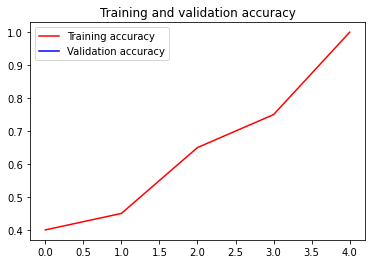

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
val_epochs = range(len(val_acc))


plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(val_epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()